In [1]:
# Make sure we are on a GPU node
try:
    import torch
    print("PyTorch is installed.")

    if torch.cuda.is_available():
        print("CUDA is available.")
        num_gpus = torch.cuda.device_count()
        print(f"Number of GPUs: {num_gpus}")
        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            print(f" - GPU {i}: {gpu_name}")
    else:
        print("CUDA is not available.")
except ImportError:
    print("PyTorch is not installed.")

PyTorch is installed.
CUDA is available.
Number of GPUs: 1
 - GPU 0: NVIDIA GeForce RTX 5060 Ti


## Attention Weights Inspection

In [2]:
from pathlib import Path

scene_id = "scene_0000"
attn_path = Path(f"./attentions_qwen2b/{scene_id}_attn.pt")  # adjust if needed

data = torch.load(attn_path, map_location="cpu")

print("Keys in file:", data.keys())

Keys in file: dict_keys(['scene_id', 'input_ids', 'attentions'])


In [3]:
print("Scene ID:", data["scene_id"])

input_ids = data["input_ids"]
attentions = data["attentions"]

print("input_ids shape:", input_ids.shape, "| dtype:", input_ids.dtype)
print("num layers:", len(attentions))

Scene ID: scene_0000
input_ids shape: torch.Size([111]) | dtype: torch.int64
num layers: 28


In [4]:
# Shapes - take layer 0 as an example
layer0 = attentions[0]
print("Layer 0 attn shape:", layer0.shape)

# Sanity check: all layers have the same shape
for l, tensor in attentions.items():
    assert tensor.shape == layer0.shape, f"Layer {l} has different shape!"
print("All layers have consistent shape.")

Layer 0 attn shape: torch.Size([12, 111, 111])
All layers have consistent shape.


In [5]:
# Average attention over heads for each layer
avg_attn_per_layer = {}

for l, A in attentions.items():
    # A: [num_heads, seq_len, seq_len]
    avg_attn_per_layer[l] = A.mean(dim=0)  # -> [seq_len, seq_len]

# Print a quick summary for a couple of layers - should be the same for every layer
for l in range(0, 28, 7):
    A = avg_attn_per_layer[l]
    print(f"Layer {l}: shape={A.shape}, "
          f"min={A.min().item():.4f}, max={A.max().item():.4f}, mean={A.mean().item():.4f}")

Layer 0: shape=torch.Size([111, 111]), min=0.0000, max=1.0000, mean=0.0090
Layer 7: shape=torch.Size([111, 111]), min=0.0000, max=1.0000, mean=0.0090
Layer 14: shape=torch.Size([111, 111]), min=0.0000, max=1.0000, mean=0.0090
Layer 21: shape=torch.Size([111, 111]), min=0.0000, max=1.0000, mean=0.0090


## Load the Annotations

In [6]:
import json

ann_path = Path("./synthetic_dataset/annotations.jsonl")

annotation_for_scene = None
with ann_path.open("r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        if rec.get("scene_id") == scene_id:
            annotation_for_scene = rec
            break

assert annotation_for_scene is not None, "No matching annotation for this scene_id"

print("Annotation keys:", annotation_for_scene.keys())
print("Relation:", annotation_for_scene["relation_AB"])
print("Caption prompt:", annotation_for_scene["caption_prompt"])

Annotation keys: dict_keys(['scene_id', 'A', 'B', 'relation_AB', 'num_distractors', 'caption_prompt'])
Relation: A_below_B
Caption prompt: Is the green square below the yellow triangle?


Image size: (256, 256)


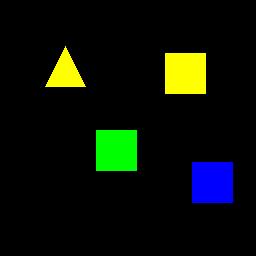

In [7]:
from PIL import Image

img_path = Path(f"./synthetic_dataset/{scene_id}.png")
img = Image.open(img_path)
print("Image size:", img.size)  # should be (256, 256)
img

## Decoding the Text Tokens

In [8]:
from transformers import AutoTokenizer

def find_token_and_visual_range(input_ids, word, model_id="Qwen/Qwen2-VL-2B-Instruct", verbose=False):
    """
    Return:
        token_idx: int or None
        visual_token_range: range
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # --- decode tokens ---
    decoded_tokens = [tokenizer.decode([tid]) for tid in input_ids.tolist()]
    if verbose:
        for i, tk in enumerate(decoded_tokens):
            print(f"{i:3d} | {repr(tk)}")

    # --- find token index for the word --- Note the added whitespace
    word_ids = tokenizer.encode(" " + word, add_special_tokens=False)
    if len(word_ids) != 1:
        raise ValueError(f"Word '{word}' does not map to a single token: got {word_ids}")

    target_tid = word_ids[0]

    # first occurrence
    matches = (input_ids == target_tid).nonzero(as_tuple=True)[0]
    token_idx = matches[0].item() if len(matches) > 0 else None

    # --- find vision token range ---
    img_start = tokenizer.convert_tokens_to_ids("<|vision_start|>")
    img_end   = tokenizer.convert_tokens_to_ids("<|vision_end|>")

    img_start_idx = (input_ids == img_start).nonzero(as_tuple=True)[0]
    img_end_idx   = (input_ids == img_end).nonzero(as_tuple=True)[0]

    if len(img_start_idx) == 0 or len(img_end_idx) == 0:
        raise ValueError("Vision start/end tokens not found in input_ids")

    img_start_idx = img_start_idx[0].item()
    img_end_idx   = img_end_idx[0].item()

    visual_token_range = range(img_start_idx + 1, img_end_idx)

    return token_idx, visual_token_range

/home/jbochniarz/jupyter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
word = "below"
token_idx, visual_token_range = find_token_and_visual_range(input_ids, word)
print(f"Token for {word}: {token_idx}. Visual token range: {len(visual_token_range)}.")

Token for below: 101. Visual token range: 81.


In [10]:
def extract_layerwise_token_attn(
    avg_attn_per_layer,
    token_idx: int,
    visual_token_range
):
    layerwise = {}

    for layer, A in avg_attn_per_layer.items():
        # A: [seq_len, seq_len]
        v = A[token_idx]                          # -> [seq_len]
        vis = v[visual_token_range].float()       # upcast here!
        layerwise[layer] = vis
    return layerwise

In [11]:
# Collect per-layer attention vectors
attn_vectors = extract_layerwise_token_attn(avg_attn_per_layer, token_idx, visual_token_range)
print("Layers:", list(attn_vectors.keys())[:5])
print("Example layer vector shape:", attn_vectors[0].shape)

Layers: [0, 1, 2, 3, 4]
Example layer vector shape: torch.Size([81])


In [12]:
import math

def vector_to_grid(vec: torch.Tensor):
    num = vec.shape[0]
    g = int(math.sqrt(num))
    assert g * g == num, f"num_vis={num} is not a square"
    grid = vec.reshape(g, g)
    return grid

def normalize_grid(grid: torch.Tensor):
    g = grid - grid.min()
    if g.max() > 0:
        g = g / g.max()
    return g
    
def get_token_attn_grid(
    attn_vectors,
    layer,
    normalize = True
):
    vis_attn = attn_vectors[layer]           # [num_vis]
    grid = vector_to_grid(vis_attn)
    
    if normalize:
        grid = normalize_grid(grid)
        
    return grid

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_token_to_image(
    attn_vectors,
    layer,
    img_path,
    title = None,
):
    grid = get_token_attn_grid(attn_vectors, layer)

    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    heatmap_small = Image.fromarray((grid.cpu().numpy() * 255).astype(np.uint8))
    heatmap = heatmap_small.resize((W, H), resample=Image.BILINEAR) # for patches use Image.NEAREST
    heatmap_np = np.array(heatmap) / 255.0

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    hm = ax.imshow(heatmap_np, alpha=0.45)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is None:
        title = f"Layer {layer}, token {token_idx}"
    ax.set_title(title)
    # plt.colorbar(hm) # Optional
    plt.tight_layout()

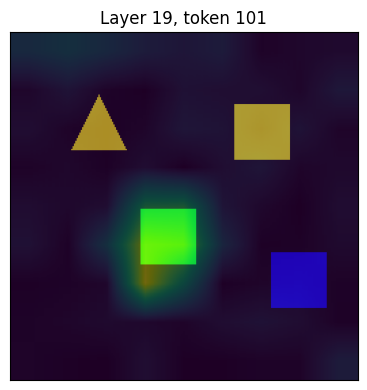

In [14]:
visualize_token_to_image(attn_vectors, layer=19, img_path=img_path)

In [15]:
layerwise_grids = {
    layer: vector_to_grid(vec)
    for layer, vec in attn_vectors.items()
}

layerwise_grids_norm = {
    layer: normalize_grid(grid)
    for layer, grid in layerwise_grids.items()
}

In [16]:
def show_layerwise_grids(layerwise_grids_norm, cols=6, figsize=(14, 12)):
    layers = sorted(layerwise_grids_norm.keys())
    rows = math.ceil(len(layers) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, layer in enumerate(layers):
        g = layerwise_grids_norm[layer].cpu().numpy()
        axes[i].imshow(g, cmap="viridis")
        axes[i].set_title(f"L{layer}")
        axes[i].axis("off")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

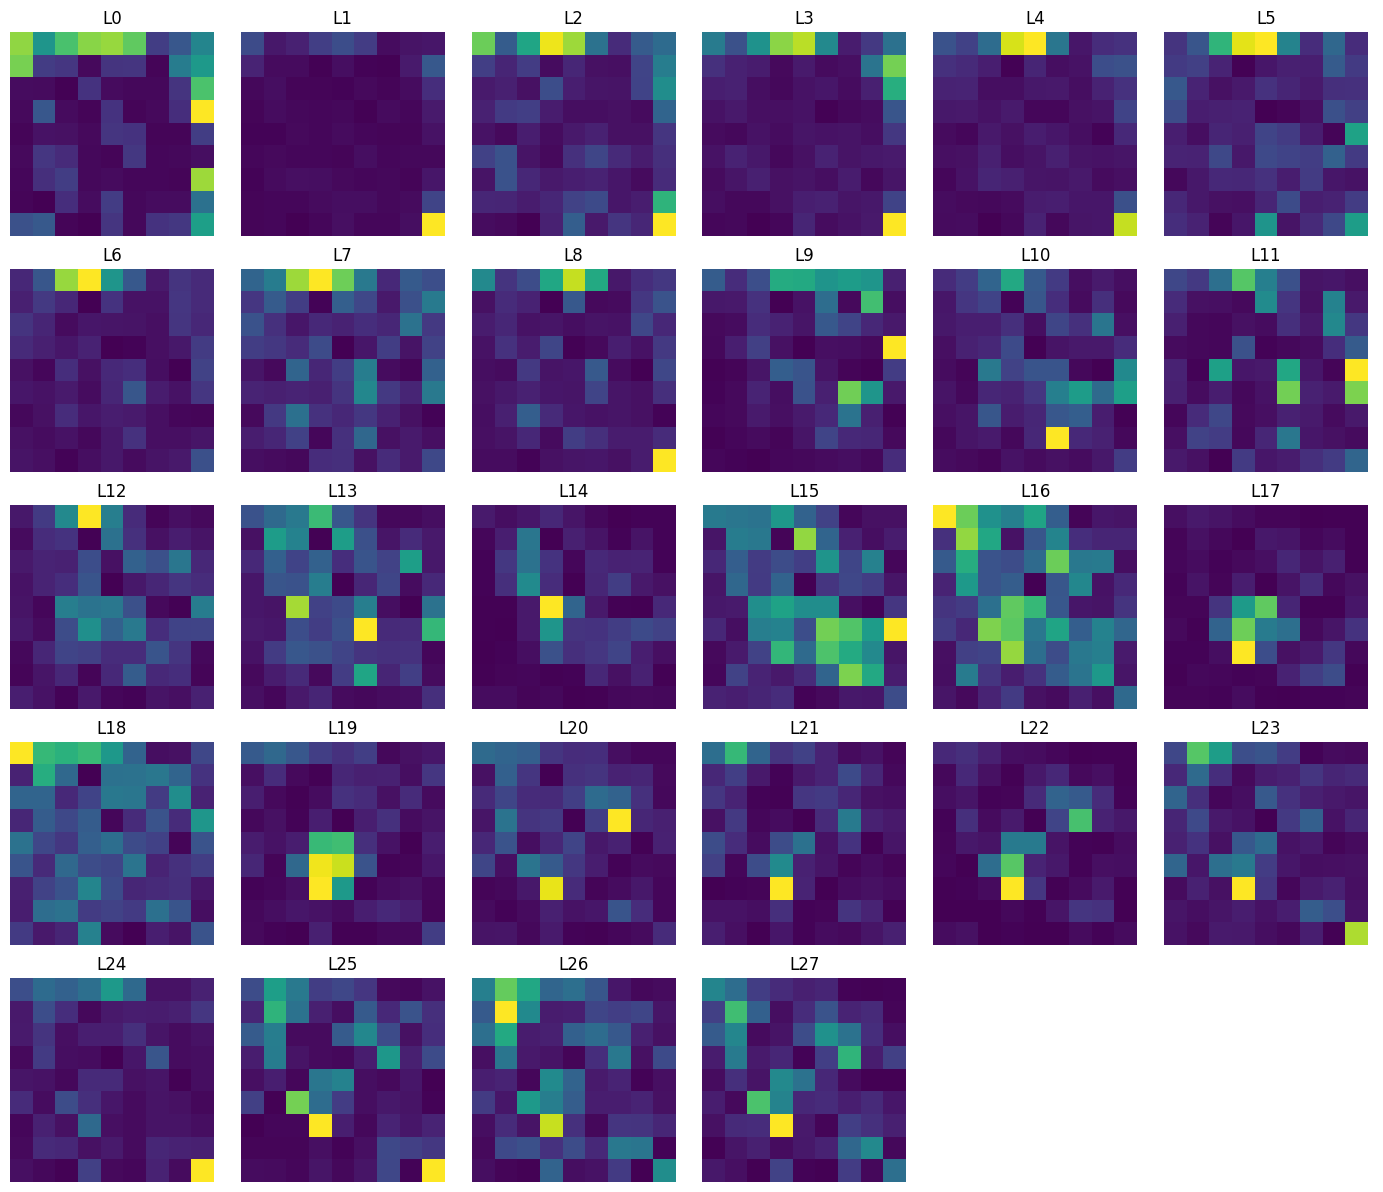

In [17]:
show_layerwise_grids(layerwise_grids_norm)

## Summary Statistics - Entropy

In [18]:
def entropy(vec):
    p = vec / (vec.sum() + 1e-8)
    logp = torch.log(p + 1e-8)
    return -(p * logp).sum().item()

In [19]:
layer_entropies = {}

for layer, vec in attn_vectors.items():
    layer_entropies[layer] = entropy(vec)

for layer, ent in layer_entropies.items():
    print(f"Layer {layer:2d}: entropy={ent:.4f}")

Layer  0: entropy=3.9147
Layer  1: entropy=3.7402
Layer  2: entropy=3.9905
Layer  3: entropy=3.7710
Layer  4: entropy=3.8573
Layer  5: entropy=4.0715
Layer  6: entropy=3.9649
Layer  7: entropy=4.1353
Layer  8: entropy=3.9668
Layer  9: entropy=3.7435
Layer 10: entropy=3.9567
Layer 11: entropy=3.8506
Layer 12: entropy=3.9932
Layer 13: entropy=3.9881
Layer 14: entropy=3.6646
Layer 15: entropy=4.0468
Layer 16: entropy=4.1278
Layer 17: entropy=3.3906
Layer 18: entropy=4.2053
Layer 19: entropy=3.6465
Layer 20: entropy=3.8889
Layer 21: entropy=3.8519
Layer 22: entropy=3.4692
Layer 23: entropy=3.9390
Layer 24: entropy=3.9866
Layer 25: entropy=3.8781
Layer 26: entropy=4.0520
Layer 27: entropy=4.0103


## Summary Statistics - IoU

In [20]:
# Ispect annotations for this scene
A = annotation_for_scene["A"]
B = annotation_for_scene["B"]
relation_AB = annotation_for_scene["relation_AB"]

print("Object A:", A)
print("Object B:", B)
print("Relation: ", relation_AB)

Object A: {'shape': 'square', 'color': 'green', 'center': [116, 150], 'bbox': [96, 130, 136, 170]}
Object B: {'shape': 'triangle', 'color': 'yellow', 'center': [65, 66], 'bbox': [45, 46, 85, 86]}
Relation:  A_below_B


In [21]:
import numpy as np

def patch_centers(side, img_w, img_h):
    patch_w = img_w / side
    patch_h = img_h / side
    xs = (np.arange(side) + 0.5) * patch_w
    ys = (np.arange(side) + 0.5) * patch_h
    # meshgrid -> (side, side, 2)
    X, Y = np.meshgrid(xs, ys)
    centers = np.stack([X, Y], axis=-1)
    return centers  # shape: (side, side, 2)
    
def relation_to_mask(annotation_for_scene: dict, centers: np.ndarray):
    """
    centers: (side, side, 2) patch centers
    returns: boolean mask (side, side)
             True (1) = patch satisfies the relation
    """
    
    A = annotation_for_scene["A"]
    B = annotation_for_scene["B"]
    Acx, Acy = A["center"]
    Bcx, Bcy = B["center"]
    r = annotation_for_scene["relation_AB"]

    X = centers[..., 0]
    Y = centers[..., 1]

    # ----------------------------
    # BELOW / ABOVE relations
    # ----------------------------
    if r == "A_below_B":
        # Region satisfying "below B"
        return Y > Bcy   # True BELOW the center of B

    if r == "A_above_B":
        return Y < Bcy   # True ABOVE the center of B

    # ----------------------------
    # LEFT / RIGHT relations
    # ----------------------------
    if r == "A_left_of_B":
        return X < Bcx   # True LEFT of B

    if r == "A_right_of_B":
        return X > Bcx   # True RIGHT of B

    raise ValueError(f"Unknown relation type: {relation}")

In [22]:
def attention_to_mask(grid, top_p=0.5):
    """Binary mask of top_p cumulative attention mass."""
    grid_np = grid.numpy()
    flat = grid_np.flatten()
    order = np.argsort(flat)[::-1]  # descending
    cumsum = np.cumsum(flat[order])
    cumsum /= cumsum[-1] + 1e-12
    keep = order[cumsum <= top_p]
    if len(keep) == 0:
        keep = order[:1]
    mask = np.zeros_like(flat, dtype=bool)
    mask[keep] = True
    return mask.reshape(grid_np.shape)

def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union if union > 0 else 0.0

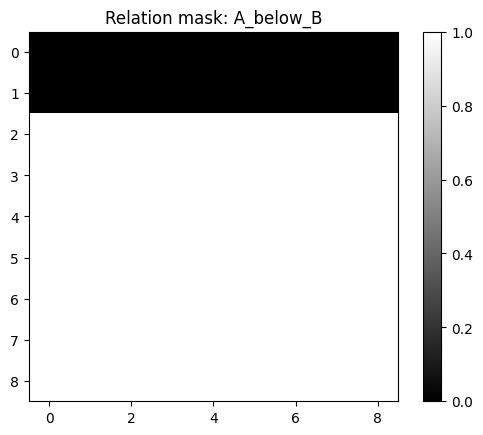

In [23]:
img = Image.open(img_path)
img_w, img_h = img.size

side = 9
centers = patch_centers(side, img_w, img_h)

mask_rel = relation_to_mask(annotation_for_scene, centers)

plt.imshow(mask_rel, cmap='gray')
plt.title(f"Relation mask: {relation_AB}")
plt.colorbar()
plt.show()

In [24]:
for layer in range(28):
    grid = layerwise_grids[layer]
    attn_mask = attention_to_mask(grid, top_p=0.5)

    iou_val = iou(attn_mask, mask_rel)
    entropy = layer_entropies[layer]

    print(f"Layer {layer:2d}: IoU={iou_val:.3f}, entropy={entropy:.3f}")

Layer  0: IoU=0.057, entropy=3.915
Layer  1: IoU=0.044, entropy=3.740
Layer  2: IoU=0.070, entropy=3.990
Layer  3: IoU=0.029, entropy=3.771
Layer  4: IoU=0.043, entropy=3.857
Layer  5: IoU=0.129, entropy=4.072
Layer  6: IoU=0.099, entropy=3.965
Layer  7: IoU=0.110, entropy=4.135
Layer  8: IoU=0.086, entropy=3.967
Layer  9: IoU=0.043, entropy=3.744
Layer 10: IoU=0.149, entropy=3.957
Layer 11: IoU=0.090, entropy=3.851
Layer 12: IoU=0.164, entropy=3.993
Layer 13: IoU=0.116, entropy=3.988
Layer 14: IoU=0.125, entropy=3.665
Layer 15: IoU=0.231, entropy=4.047
Layer 16: IoU=0.171, entropy=4.128
Layer 17: IoU=0.079, entropy=3.391
Layer 18: IoU=0.164, entropy=4.205
Layer 19: IoU=0.111, entropy=3.647
Layer 20: IoU=0.134, entropy=3.889
Layer 21: IoU=0.103, entropy=3.852
Layer 22: IoU=0.095, entropy=3.469
Layer 23: IoU=0.152, entropy=3.939
Layer 24: IoU=0.086, entropy=3.987
Layer 25: IoU=0.136, entropy=3.878
Layer 26: IoU=0.162, entropy=4.052
Layer 27: IoU=0.185, entropy=4.010
